In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from  torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
torch.cuda.set_device(0)

## 使用 Mnist 作為訓練資料

In [3]:

train_dataset = datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset = datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

In [8]:
print('train_dataset train_data:',train_dataset.train_data.size())
print('train_dataset train_labels:',train_dataset.train_labels.size())
print('test_dataset test_data:',test_dataset.test_data.size())
print('test_dataset test_labes:',test_dataset.test_labels.size())

train_dataset train_data: torch.Size([60000, 28, 28])
train_dataset train_labels: torch.Size([60000])
test_dataset test_data: torch.Size([10000, 28, 28])
test_dataset test_labes: torch.Size([10000])


## 設定參數跟網路

In [11]:
batch_size = 100 # 一組100個
n_iters = 3000 # 訓練總數3000次

# 計算訓練週期  總次數/(總資料數量/每次訓練資料數)
num_epochs = n_iters / (len(train_dataset)/batch_size) 
num_epochs = int(num_epochs) # 這裡可簡單算出訓練週期為5

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size=batch_size,shuffle=True)

In [34]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        # conv1 (1,28,28)
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2)
        self.relu1 = nn.ReLU() # (16,28,28) 28+4-5+1  pad=2,ke=5,中心
        # max 1 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) # ((16,14,14))
        
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2)
        self.relu2 =nn.ReLU() # (32,14,14) 14+4-5+1
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # (32,7,7)
        
        # fully connected layer
        self.fc1 = nn.Linear(32*7*7,10)
    def forward(self,x):
        # conv 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # conv 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # flatten
        x = x.view(x.size(0),-1) # x.size(0)好像指的是600個batch
        out = self.fc1(x)

        return out

In [35]:
model = CNNModel()
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

## 訓練

In [39]:
iters = 0 
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        # convert tensor to Variable
        images = Variable(images)
        labels = Variable(labels)
        
        # clear gradient w.r.t parameters
        optimizer.zero_grad() # 這邊要歸零 不然重新做會影響下次計算
        
        # forward pass
        outputs = model(images)
        
        # caclculate loss
        loss = loss_func(outputs,labels)
        
        # get gradient w.r.t parameters
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        iters += 1
        
        if iters % 500 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images)
                # predict with current weights 
                outputs = model(images)
                # get prediction via via max-value
                _,predicted = torch.max(outputs.data,1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / total
            print("Iteration: {}. Loss: {}. Accuracy:{}".format(iters,loss.data[0],accuracy))
            


Iteration: 500. Loss: 0.09691331535577774. Accuracy:95.99
Iteration: 1000. Loss: 0.16378647089004517. Accuracy:96.72
Iteration: 1500. Loss: 0.0893184021115303. Accuracy:96.96
Iteration: 2000. Loss: 0.05155602842569351. Accuracy:97.02
Iteration: 2500. Loss: 0.09618135541677475. Accuracy:97.49
Iteration: 3000. Loss: 0.09384986013174057. Accuracy:97.71


## 觀看結果

torch.Size([16, 1, 5, 5])


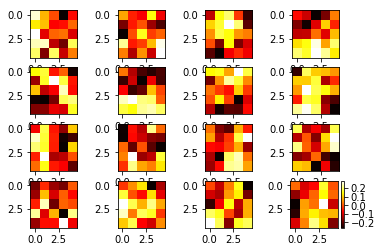

In [42]:
# get filters from parameters
print(list(model.parameters())[0].size()) # (16,1,5,5)
fig = plt.figure()
axes = []
for i in range(4):
    for j in range(4):
        ax = plt.subplot2grid((4,4),(i,j),colspan=1,rowspan=1)
        axes.append(ax)
        
for i in range(16):
    im = axes[i].imshow(list(model.parameters())[0].data.numpy()[i,0,:,:],cmap='hot')
plt.colorbar(im)
plt.show()